In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import d2l
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve, auc

### Define Single Layer NN


In [2]:
class Net(nn.Module):
    def __init__(self,features,H):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(features, H)
        self.fc2 = nn.Linear(H, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Binary Classification

In [3]:
def load_data(path):
    """
    Load the .npz data according to path
    """
    file = np.load('datasets/bi-class/'+path+'.npz') #read
    train_X,train_Y,test_X,test_Y = file['train_X'],file['train_Y'],file['test_X'],file['test_Y']
    return train_X,train_Y,test_X,test_Y

In [4]:
def find_optimal_unit_size(train_X,train_Y,epochs,batch_size,lr):
    """
    Find the best H using cross-validation
    """
    LOSS,ACC = [0]*10,[0]*10
    
    index_80 = np.random.choice(range(len(train_X)),size = int(0.8*len(train_X)),replace=False) #randomly select 80% index of train
    index_20 = list(set(range(len(train_X))) - set(index_80)) #the remained 20% index for validation
    train_X_80,train_Y_80 = train_X[index_80,:],train_Y[index_80] #split
    train_X_20,train_Y_20 = train_X[index_20,:],train_Y[index_20] #split
    
    for H in range(1,11,1): #For each hidden unit
        # network
        net = Net(train_X.shape[1],H)
        # loss
        criterion = nn.CrossEntropyLoss()
        # optimizer
        optimizer = optim.SGD(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97, last_epoch=-1, verbose=False) #lr scheduler
        
        for m in net.modules(): #Initialization
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)

        for epoch in range(epochs):
            start,n = 0,len(train_X_80)
            while start < n: #Mini-batch-gradient-descent
                end = min(n,start+batch_size)
                X = torch.Tensor(train_X_80[start:end,:]).float()
                Y = torch.Tensor(train_Y_80[start:end]).long()
                optimizer.zero_grad()
                out = net(X) 
                loss = criterion(out, Y)
                loss.backward() 
                optimizer.step()
                start += batch_size
            scheduler.step()
            
        #Evalaute the model in last 20% training data
        X = torch.Tensor(train_X_20).float()
        Y = torch.Tensor(train_Y_20).long()
        out = net(X)
        loss = criterion(out, Y)
        _, predicted = torch.max(out.data, 1)
        acc = torch.sum(Y==predicted).double() / len(Y)
        LOSS[H-1] = loss.detach().numpy()
        ACC[H-1] = acc

    best_h = LOSS.index(min(LOSS))+1 #find the best h according to minimum loss value
    return best_h,LOSS,ACC

In [5]:
def predict(h,train_X,train_Y,test_X,test_Y,epochs,batch_size,lr):
    """
    Predict the testing dataset using the best H
    """
    net = Net(train_X.shape[1],h)
    # loss
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97, last_epoch=-1, verbose=False)
    
    for m in net.modules():#initialization
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            
    for epoch in range(epochs):
        start,n = 0,len(train_X)
        while start < n:#Mini-batch-gradient-descent
            end = min(n,start+batch_size)
            X = torch.Tensor(train_X[start:end,:]).float()
            Y = torch.Tensor(train_Y[start:end]).long()
            optimizer.zero_grad()
            out = net(X) 
            loss = criterion(out, Y)
            loss.backward() 
            optimizer.step()
            start += batch_size  
        scheduler.step()
        
    #get prediction
    X_train = torch.Tensor(train_X).float()
    Y_train = torch.Tensor(train_Y).long()
    out_train = net(X_train)
    loss_train = criterion(out_train, Y_train)

    X_test = torch.Tensor(test_X).float()
    Y_test = torch.Tensor(test_Y).long()
    out_test = net(X_test)
    loss_test = criterion(out_test, Y_test)
    return loss_train.detach().numpy(),out_train,loss_test.detach().numpy(),out_test

In [6]:
def analyze_prediction(path,train_Y,test_Y,out_train,out_test):
    """
    Get the Accuracy of Train set & Test set and plot the confusion matrix
    """
    train_Y = torch.Tensor(train_Y).long() #convert to tensor
    test_Y = torch.Tensor(test_Y).long() #convert to tensor
    
    train_predicted = torch.max(out_train.data, 1)[1] #compute true prediction
    test_predicted = torch.max(out_test.data, 1)[1]
    
    train_acc = torch.sum(train_Y==train_predicted).double() / len(train_Y) #calculate accuracy
    test_acc = torch.sum(test_Y==test_predicted).double() / len(test_Y)
    
    sns.set()
    plt.style.use(['science','ieee','std-colors','no-latex'])
    f,ax=plt.subplots(figsize=[4,4],dpi=150)
    C2= confusion_matrix(test_Y, test_predicted) #confusion matrix
    sns.heatmap(C2,annot=True,ax=ax) 
    ax.set_title('confusion matrix of '+path) 
    ax.set_xlabel('predict') 
    ax.set_ylabel('true')
    plt.savefig('confusion_matrix_binary_'+path+'.png',dpi=200)
    
    return train_acc,test_acc

The best H for breast-cancer is 5
DATA : breast-cancer. The Training Loss is 0.09843399375677109, The Testing Loss is 0.10539934039115906
DATA : breast-cancer.The Training accuracy is 0.9616087751371115, The Testing accuracy is 0.9558823529411765
------------------------------
The best H for diabetes is 9
DATA : diabetes. The Training Loss is 0.5480208992958069, The Testing Loss is 0.6056622266769409
DATA : diabetes.The Training accuracy is 0.7056910569105691, The Testing accuracy is 0.6535947712418301
------------------------------
The best H for iris is 6
DATA : iris. The Training Loss is 0.04755854606628418, The Testing Loss is 0.06134103983640671
DATA : iris.The Training accuracy is 1.0, The Testing accuracy is 1.0
------------------------------
The best H for wine is 2
DATA : wine. The Training Loss is 0.6764610409736633, The Testing Loss is 0.6733884811401367
DATA : wine.The Training accuracy is 0.5985915492957746, The Testing accuracy is 0.6111111111111112
----------------------

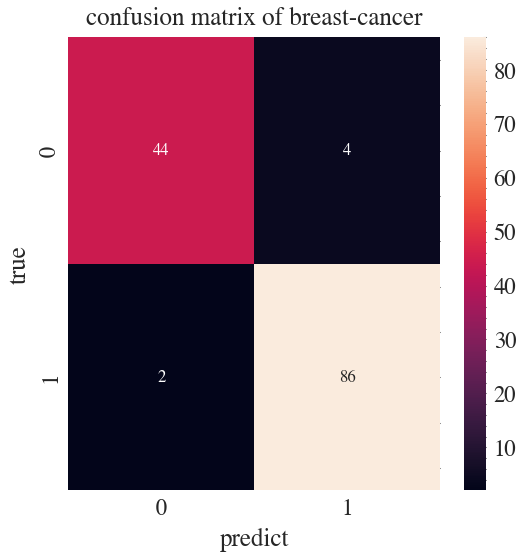

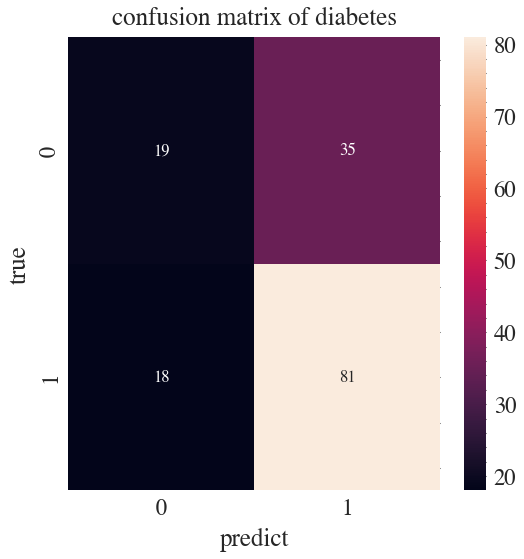

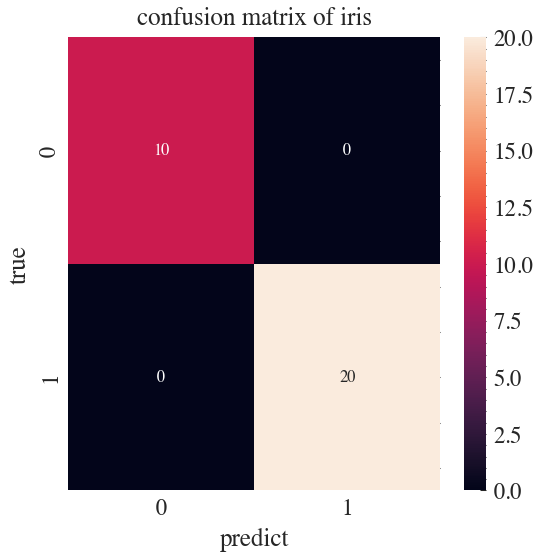

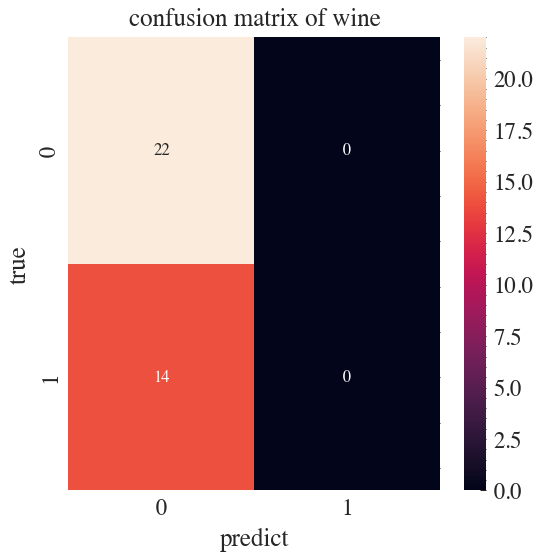

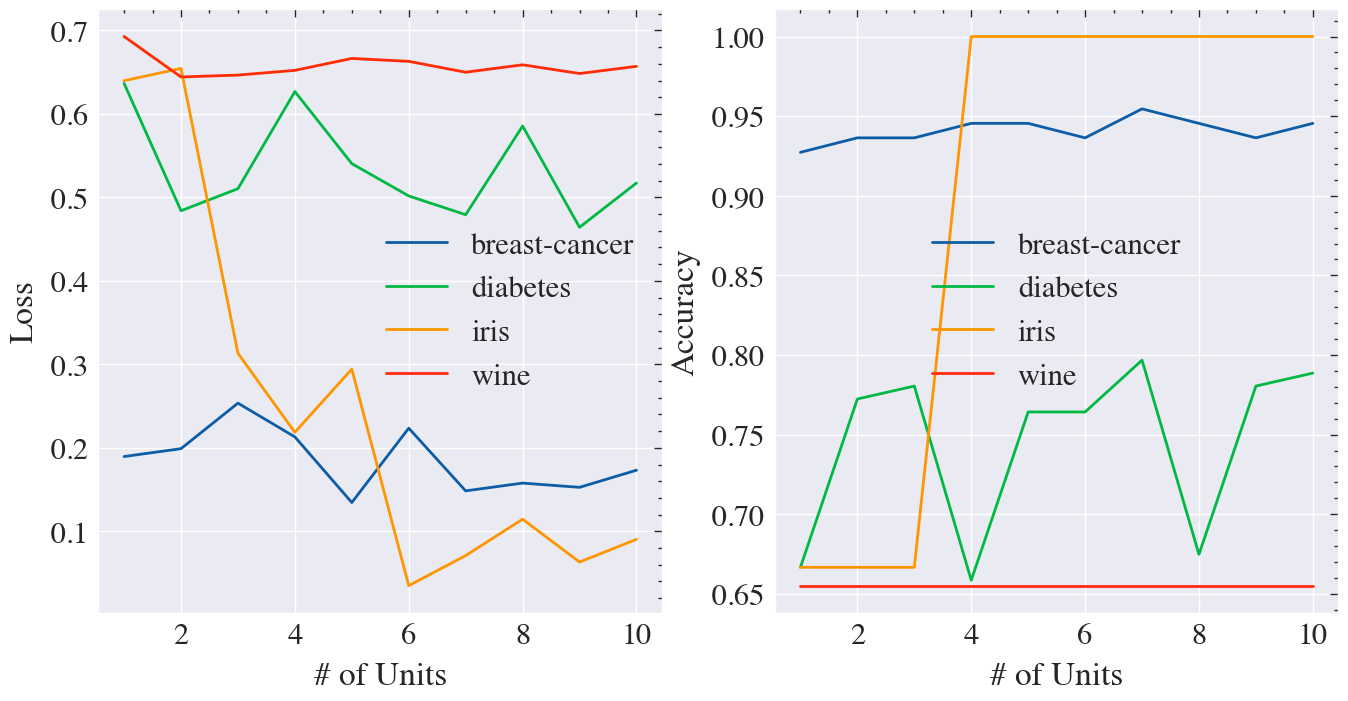

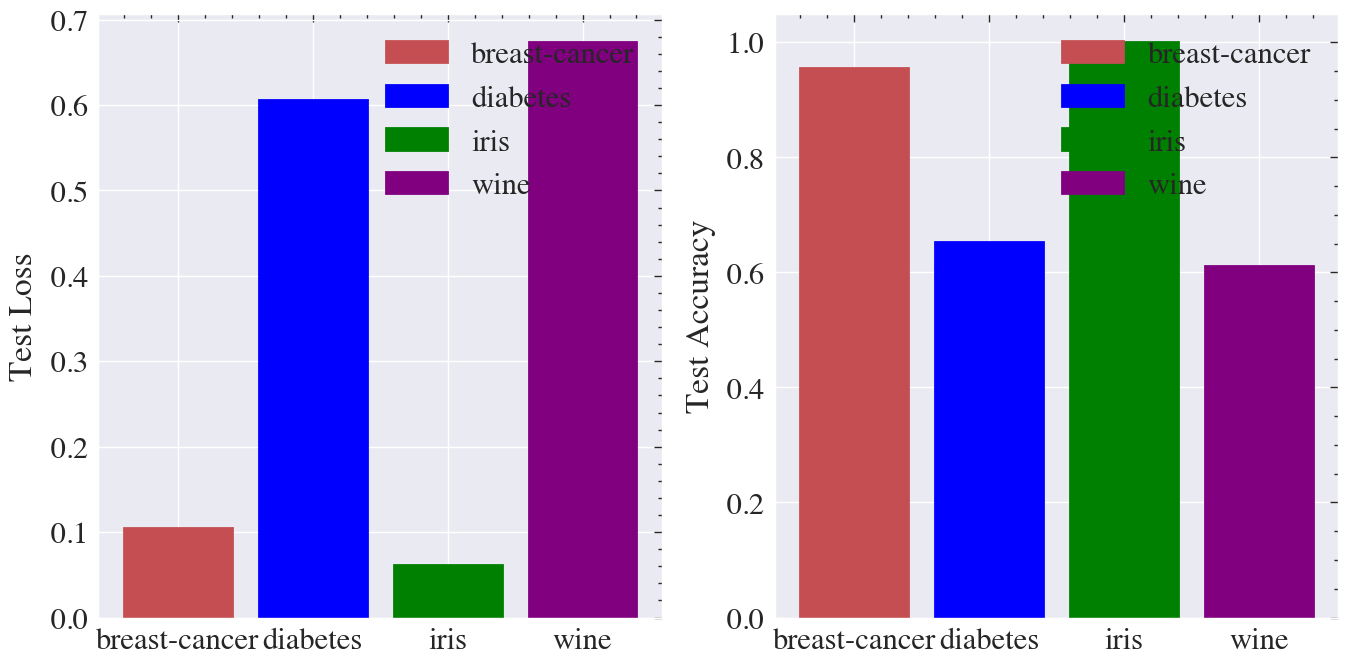

In [12]:
if __name__ == "__main__": #Main function
    #Training Params
    epochs = 200
    batch_size = 16
    lr = 0.01
    
    paths = ['breast-cancer','diabetes','iris','wine'] 
    LOSSES, ACCS,test_acc,test_loss = [],[],[],[]
    
    for path in paths:
        train_X,train_Y,test_X,test_Y = load_data(path) #get data
        h, LOSS, ACC= find_optimal_unit_size(train_X,train_Y,epochs,batch_size,lr) #get h and tuning process
        print('The best H for {} is {}'.format(path,h))
        LOSSES.append(LOSS)
        ACCS.append(ACC)
        loss_train,out_train,loss_test,out_test = predict(h,train_X,train_Y,test_X,test_Y,epochs,batch_size,lr) #get loss and prediciton of testset
        print('DATA : {}. The Training Loss is {}, The Testing Loss is {}'.format(path,loss_train,loss_test))
        test_loss.append(loss_test)
        acc_train,acc_test = analyze_prediction(path,train_Y,test_Y,out_train,out_test) #analyze the prediction performance
        print('DATA : {}.The Training accuracy is {}, The Testing accuracy is {}'.format(path,acc_train,acc_test))
        print("------------------------------")
        test_acc.append(acc_test)
    
    # Plot the tuning process
    plt.style.use(['science','ieee','std-colors','no-latex'])
    fig = plt.figure(figsize=[8,4],dpi=200)
    fig.patch.set_facecolor('#FFFFFF')
    plt.grid(color='grey', linestyle='-.', linewidth=0.2)
    plt.subplot(1,2,1)
    for i in range(4):
        plt.plot(range(1,11),LOSSES[i],label=paths[i])
    plt.xlabel('# of Units')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    for i in range(4):
        plt.plot(range(1,11),ACCS[i],label=paths[i])
    plt.xlabel('# of Units')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('binary_exp.png',dpi=200)
    
    #plot the test result
    plt.style.use(['science','ieee','std-colors','no-latex'])
    fig = plt.figure(figsize=[8,4],dpi=200)
    fig.patch.set_facecolor('#FFFFFF')
    plt.grid(color='grey', linestyle='-.', linewidth=0.2)
    plt.subplot(1,2,1)
    lineObjects = plt.bar(range(4),test_loss)
    lineObjects[0].set_color('r')
    lineObjects[1].set_color('blue')
    lineObjects[2].set_color('green')
    lineObjects[3].set_color('purple')
    plt.legend(iter(lineObjects),paths)
    plt.xticks(ticks=range(4),labels=paths)
    plt.ylabel("Test Loss")
    plt.subplot(1,2,2)
    lineObjects = plt.bar(range(4),test_acc)
    lineObjects[0].set_color('r')
    lineObjects[1].set_color('blue')
    lineObjects[2].set_color('green')
    lineObjects[3].set_color('purple')
    plt.legend(iter(lineObjects),paths)
    plt.xticks(ticks=range(4),labels=paths)
    plt.ylabel("Test Accuracy")
    plt.savefig('binary_test.png',dpi=200)
    